# Customer Segmentation in Bank A

**Team:** Anurag, Elina, Tosin

**Dataset:** 8500 customers and their activity over a 6-month period. Each transaction is characterized by 18 features described below.

**Task:** find the most useful customer segmentation to improve the marketing campaigns of the company.

In [ ]:
# Import Libraries

# ----------------------------------GENERAL---------------------------------

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------VISUALIZATION---------------------------

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# ----------------------------------PRE-PROCESSING---------------------------

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

# ----------------------------------PIPELINE AND MODELS----------------------

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [ ]:
# Load data
# card_transactions.csv
gdrive_data_url = "https://drive.google.com/file/d/1yg9yn0qMNNK5UlgqFX7xjrF6jg3Xu88j/view?usp=sharing"
file_id = gdrive_data_url.split('/')[-2]
data_file='https://drive.google.com/uc?export=download&id=' + file_id
df_orig = pd.read_csv(data_file)
df_orig.head()

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


In [ ]:
# Create a copy of the dataset to work on
df = df_orig.copy()

### Clean and Explore the dataset

In [ ]:
df.shape

(8500, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       8500 non-null   object 
 1   balance_account                   8500 non-null   float64
 2   purchases_amount                  8500 non-null   float64
 3   paid_advance                      8500 non-null   float64
 4   full_purchases                    8500 non-null   float64
 5   balance_frequency_update          8500 non-null   float64
 6   installments                      8500 non-null   float64
 7   purchases_frequency               8500 non-null   float64
 8   full_purchases_frequency          8500 non-null   float64
 9   purchases_installments_frequency  8500 non-null   float64
 10  cash_advance_frequency            8500 non-null   float64
 11  nr_cash_advances                  8500 non-null   int64  
 12  nr_pur

In [ ]:
missing_values = df.isna().sum()
missing_values

customer_id                           0
balance_account                       0
purchases_amount                      0
paid_advance                          0
full_purchases                        0
balance_frequency_update              0
installments                          0
purchases_frequency                   0
full_purchases_frequency              0
purchases_installments_frequency      0
cash_advance_frequency                0
nr_cash_advances                      0
nr_purchases                          0
credit_limit                          1
fixed_rate_period                     0
payments                              0
min_payments                        298
full_payment_prc                      0
dtype: int64

In [ ]:
# Check for duplicates
duplicate_ids = (df["customer_id"].value_counts() > 1).sum()
duplicate_ids

0

*   The dataset has 18 columns and 8500 rows.

*   The customer_id is as an object datatype.

*   Other features are as int64 or float64 datatype.

*   There are missing values:

  *   credit_limit: 1 missing value
  *   min_payments: 298 missing values

*   There are no duplicates in the dataset.

*We have previously identified (see notebook EV_MLG_Group_Challenge_Customer_Segmentation) that there are outliers in the dataset.*

*We also identified columns that we want to drop before running Kmeans.*

In [ ]:
# Drop unneccesary columns
df = df.drop(columns=["customer_id","min_payments","full_payment_prc","fixed_rate_period"])

In [ ]:
df.shape

(8500, 14)

In [ ]:
# Drop rows where cash_advance_frequency is above 1
df = df[df["cash_advance_frequency"] <= 1]
df.shape

(8492, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8492 entries, 0 to 8499
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   balance_account                   8492 non-null   float64
 1   purchases_amount                  8492 non-null   float64
 2   paid_advance                      8492 non-null   float64
 3   full_purchases                    8492 non-null   float64
 4   balance_frequency_update          8492 non-null   float64
 5   installments                      8492 non-null   float64
 6   purchases_frequency               8492 non-null   float64
 7   full_purchases_frequency          8492 non-null   float64
 8   purchases_installments_frequency  8492 non-null   float64
 9   cash_advance_frequency            8492 non-null   float64
 10  nr_cash_advances                  8492 non-null   int64  
 11  nr_purchases                      8492 non-null   int64  
 12  credit

In [ ]:
# Removing NaN values
df.dropna(inplace=True)
df.shape

(8491, 14)

In [ ]:
# Removing outliers
from scipy import stats
print("Dataset with outliers ", df.shape)
df_no = df[(np.abs(stats.zscore(df))<3).all(axis=1)]
print("Dataset without outliers ", df_no.shape)

Dataset with outliers  (8491, 14)
Dataset without outliers  (7469, 14)


### Visualize the data

In [ ]:
# Scaling the features before plotting
scaler = StandardScaler()
df_no_scaled = pd.DataFrame(scaler.fit_transform(df_no), columns=df_no.columns)

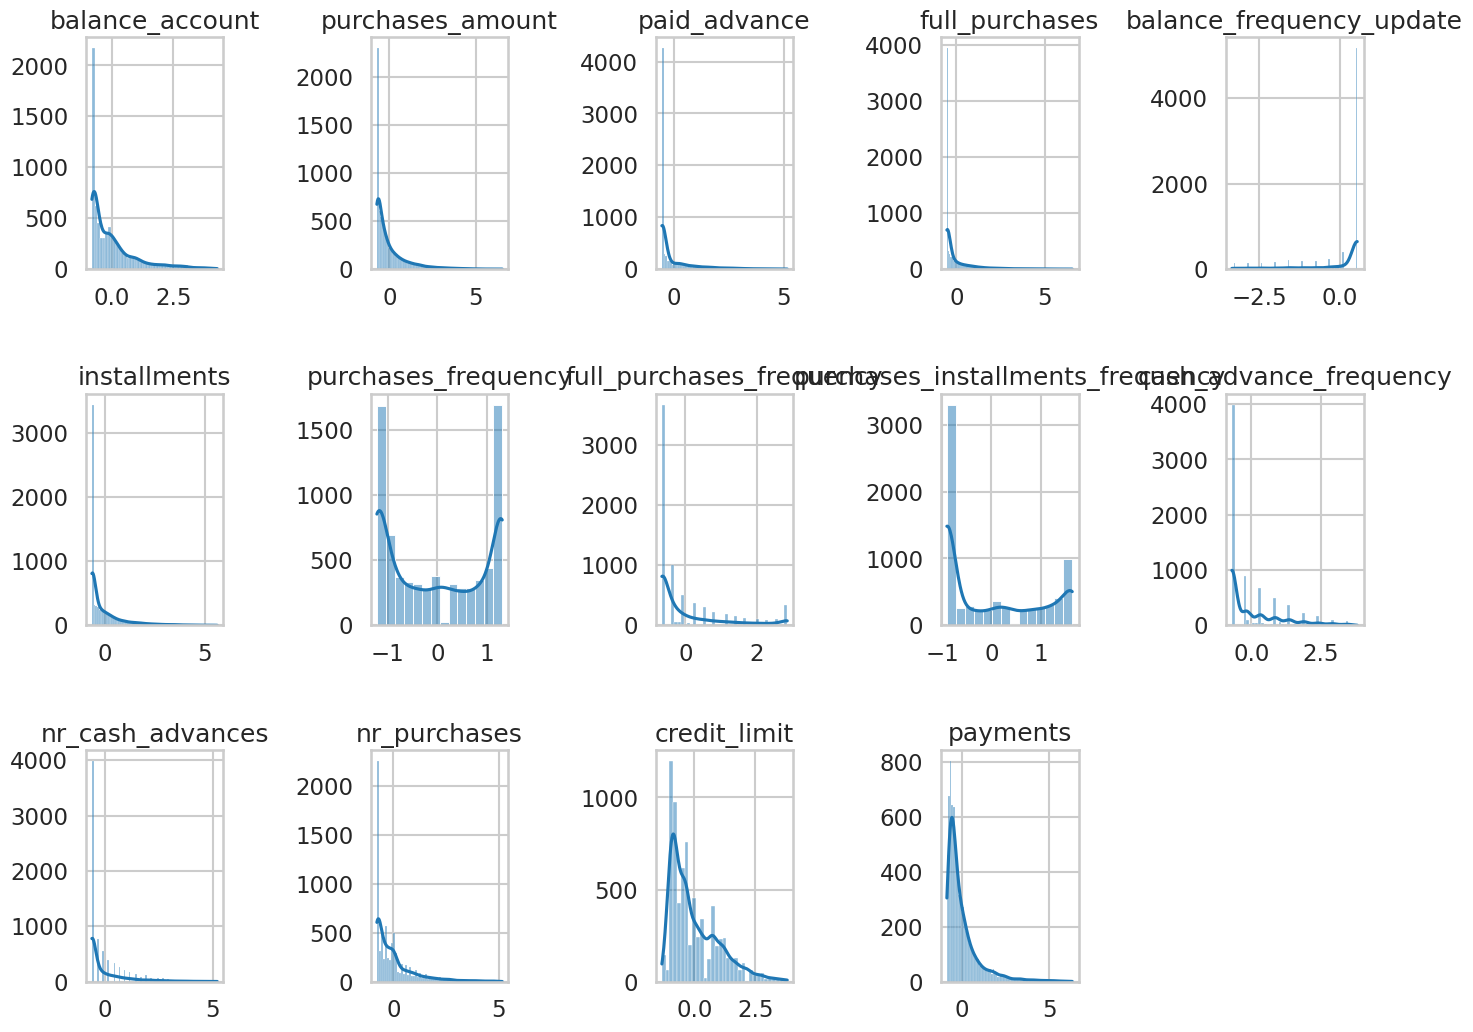

In [ ]:
# Plot histograms of all features

# Set up subplots
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 15))
fig.tight_layout(pad=3.0)

# Flatten the 2D array of subplots
ax = ax.flatten()

# Plot histograms for each feature
for i, column in enumerate(df_no_scaled.columns):
    sns.histplot(df_no_scaled[column], ax=ax[i], kde=True)
    ax[i].set_title(column)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)

# Hide empty subplots
for i in range(len(df_no_scaled.columns), len(ax)):
    fig.delaxes(ax[i])

plt.show()

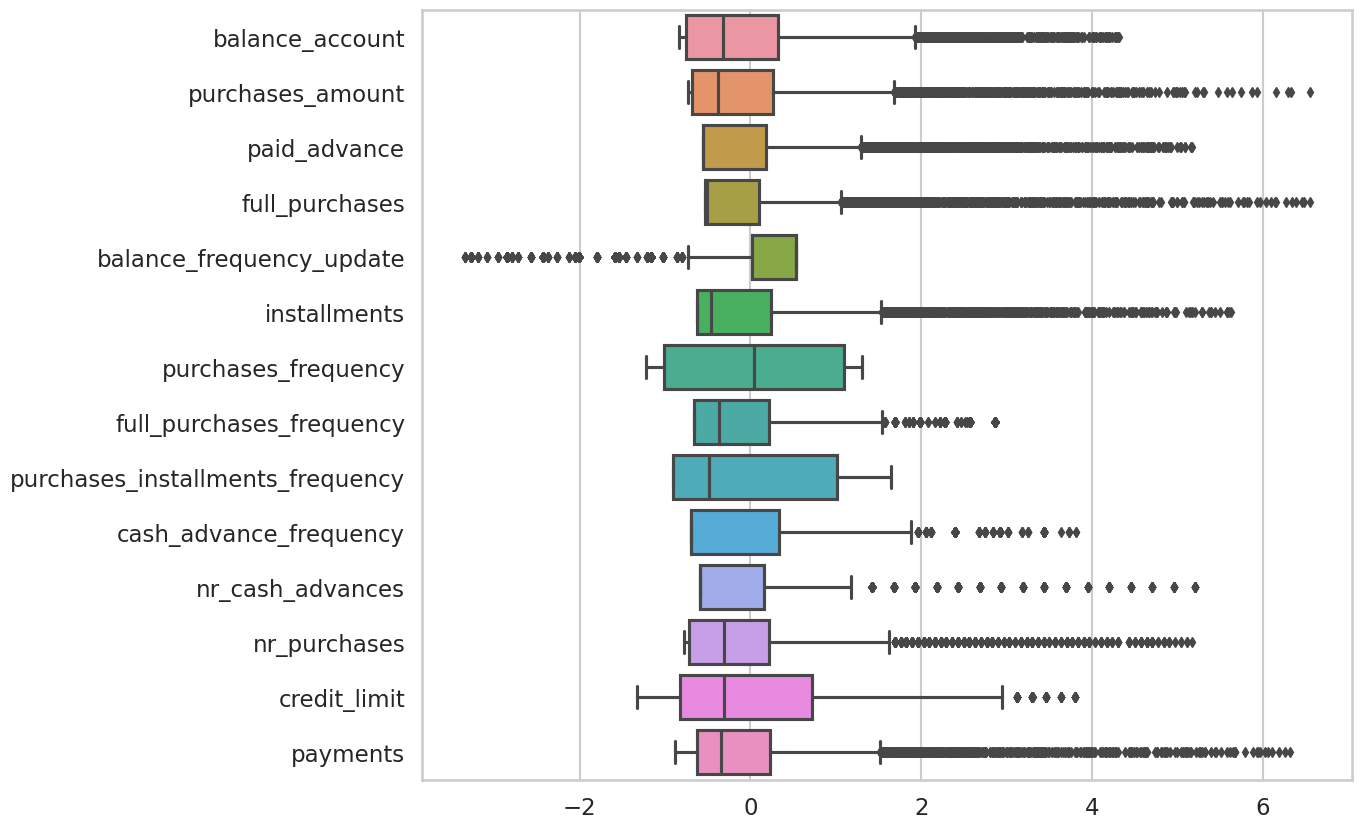

In [ ]:
# Boxplots for each feature
plt.figure(figsize=(12, 10))
ax = sns.boxplot(data=df_no_scaled, orient='h')
#plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

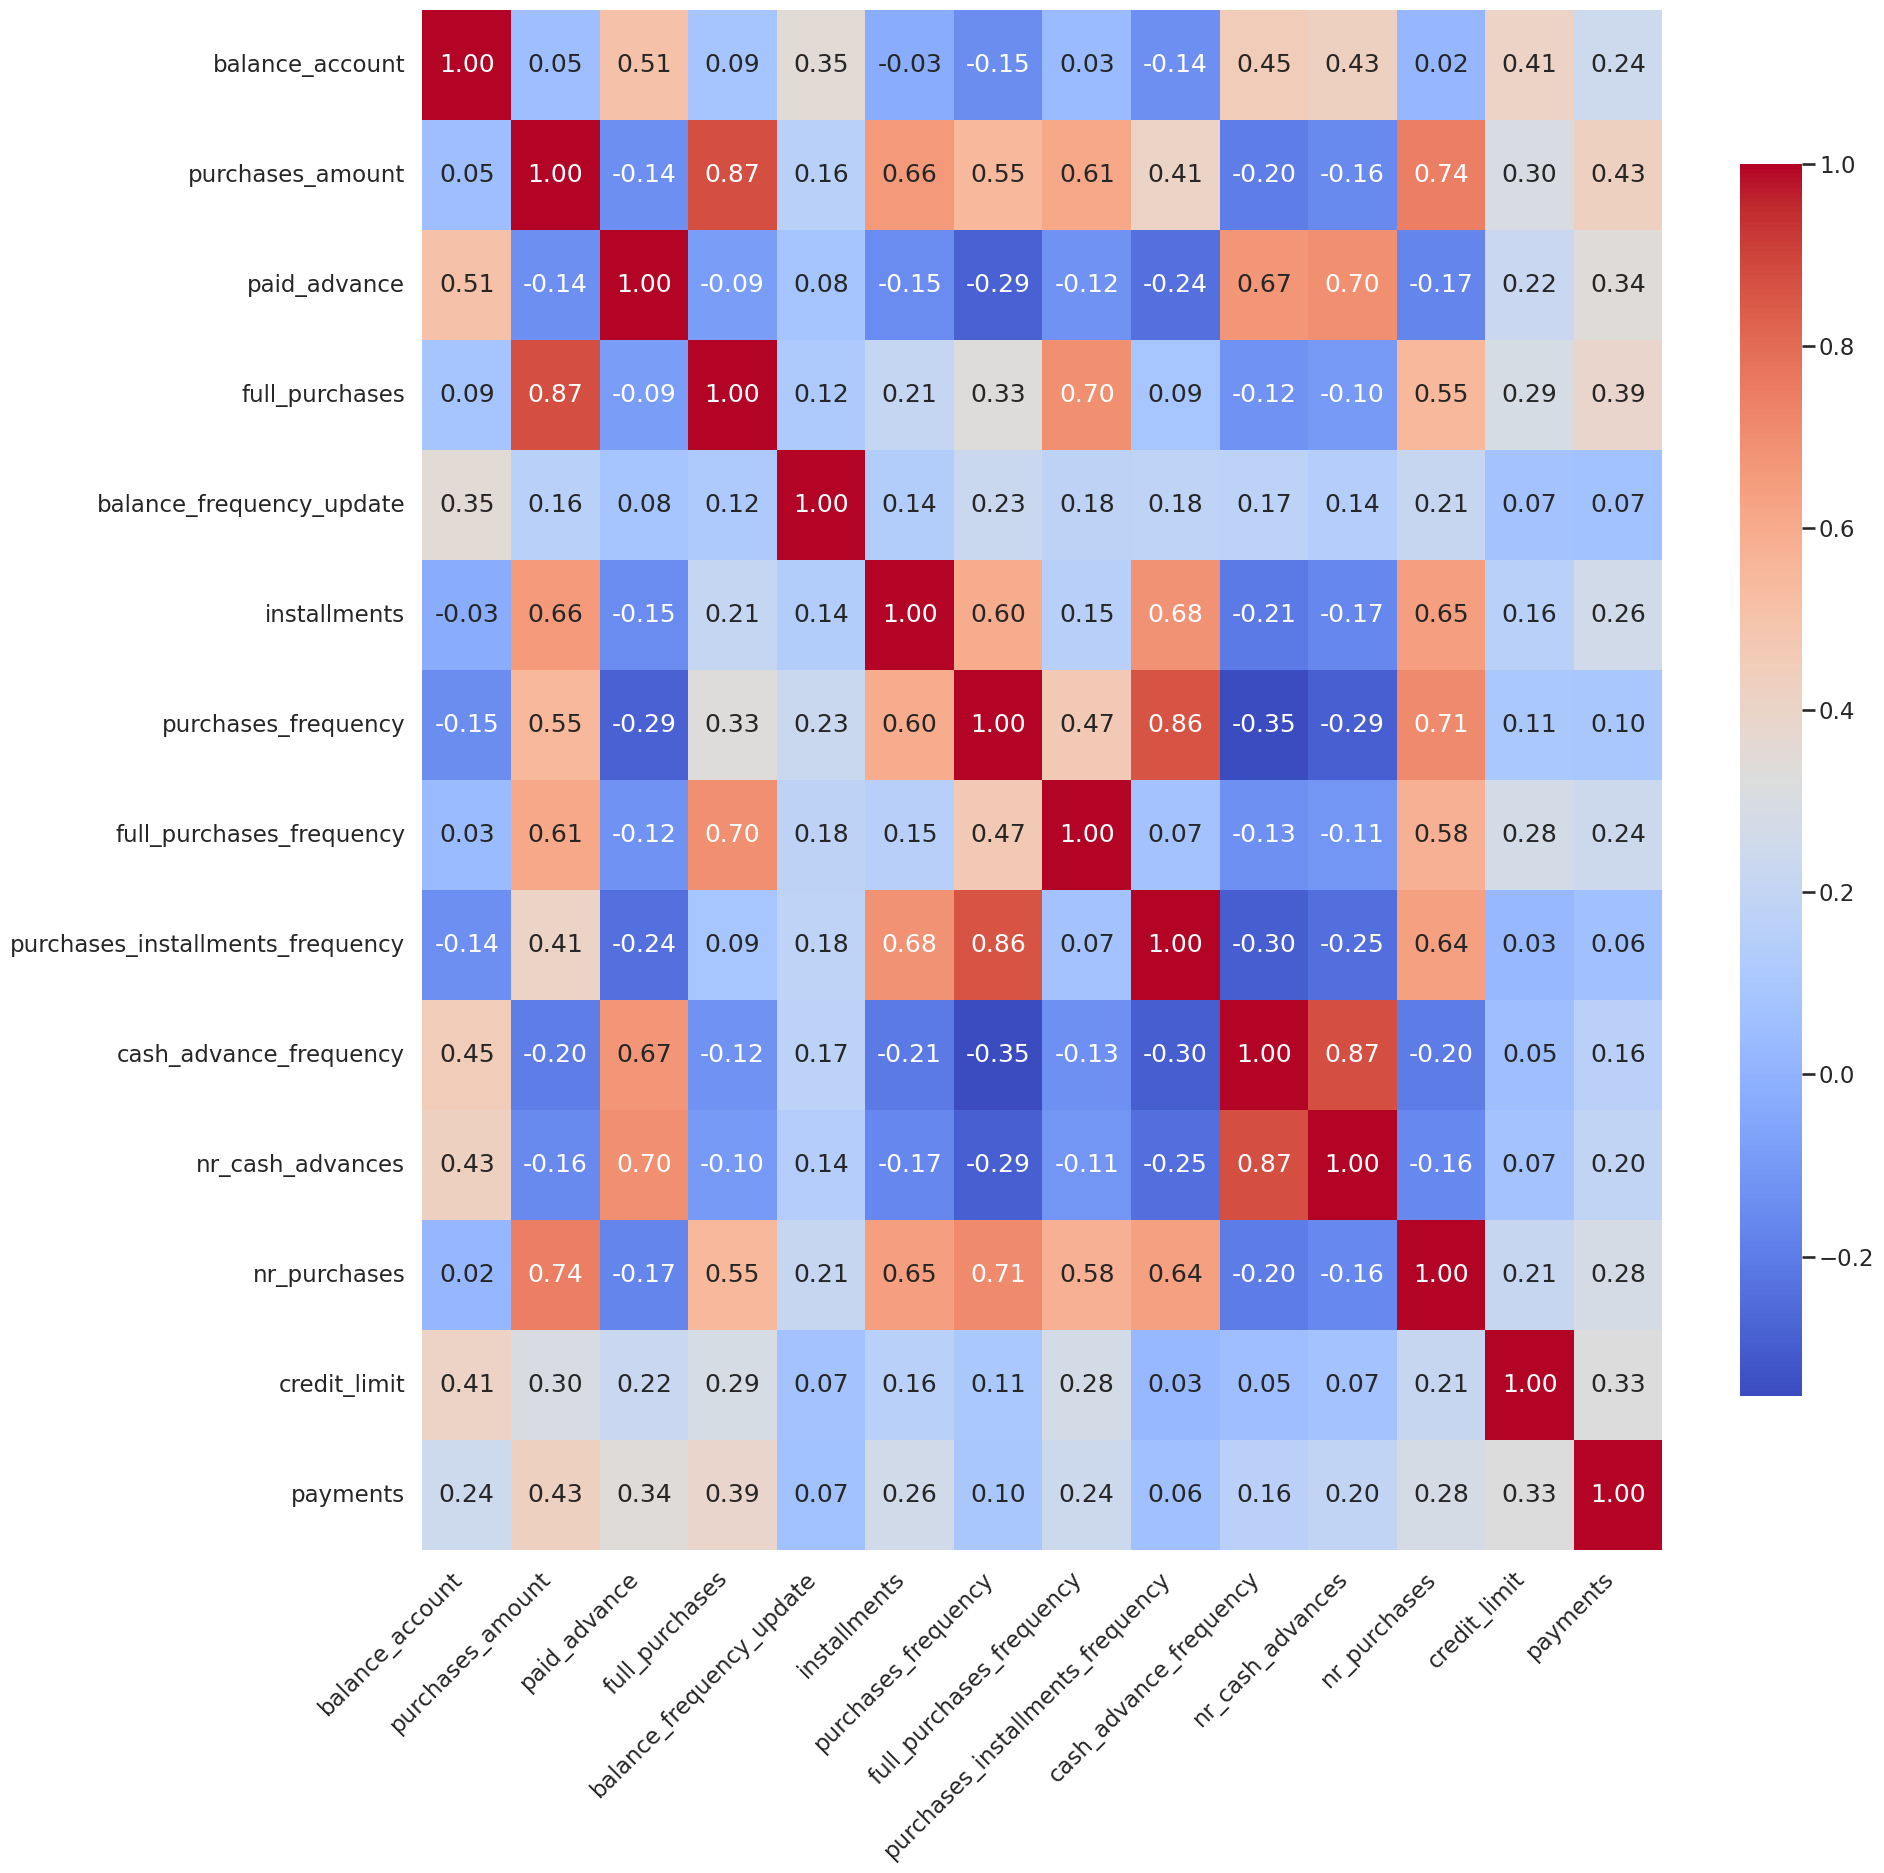

In [ ]:
# Plot a heatmap
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(df_no_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"shrink": 0.8})

# Rotate x-axis labels for better readability
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

### Finding the optimal number of Clusters

For n_clusters = 2 The average silhouette_score is : 0.0742
For n_clusters = 3 The average silhouette_score is : 0.2111
For n_clusters = 4 The average silhouette_score is : 0.0145
For n_clusters = 5 The average silhouette_score is : 0.0157
For n_clusters = 6 The average silhouette_score is : 0.0033
For n_clusters = 7 The average silhouette_score is : -0.019
For n_clusters = 8 The average silhouette_score is : -0.0123
For n_clusters = 9 The average silhouette_score is : -0.0019
For n_clusters = 10 The average silhouette_score is : -0.0137
For n_clusters = 11 The average silhouette_score is : -0.0225
For n_clusters = 12 The average silhouette_score is : -0.0272
For n_clusters = 13 The average silhouette_score is : -0.0281
For n_clusters = 14 The average silhouette_score is : -0.0271
For n_clusters = 15 The average silhouette_score is : -0.0517
For n_clusters = 16 The average silhouette_score is : -0.0364
For n_clusters = 17 The average silhouette_score is : -0.0501
For n_clusters = 18 Th

Text(0, 0.5, 'Silhouette Score')

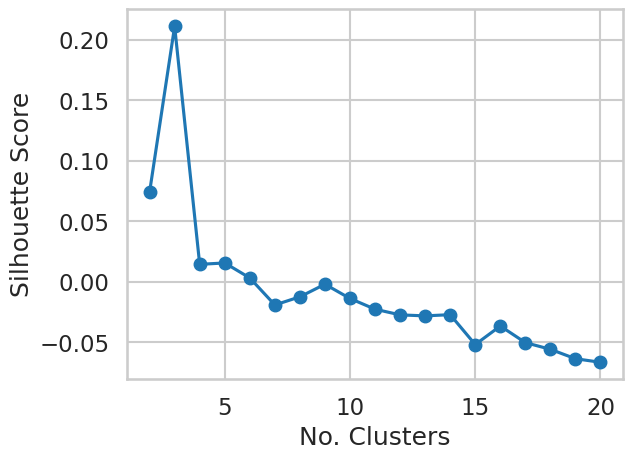

In [ ]:
silhouette_s = []

for n_clusters in range(2, 21):
    kmeans_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=42, verbose=0))])

    cluster_labels = kmeans_pipeline.fit_predict(df_no)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_no, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(df_no, cluster_labels))

plt.plot(range(2, 21),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")

For n_clusters = 2 The average silhouette_score is : 0.074
For n_clusters = 3 The average silhouette_score is : 0.2111
For n_clusters = 4 The average silhouette_score is : 0.0145
For n_clusters = 5 The average silhouette_score is : 0.0158




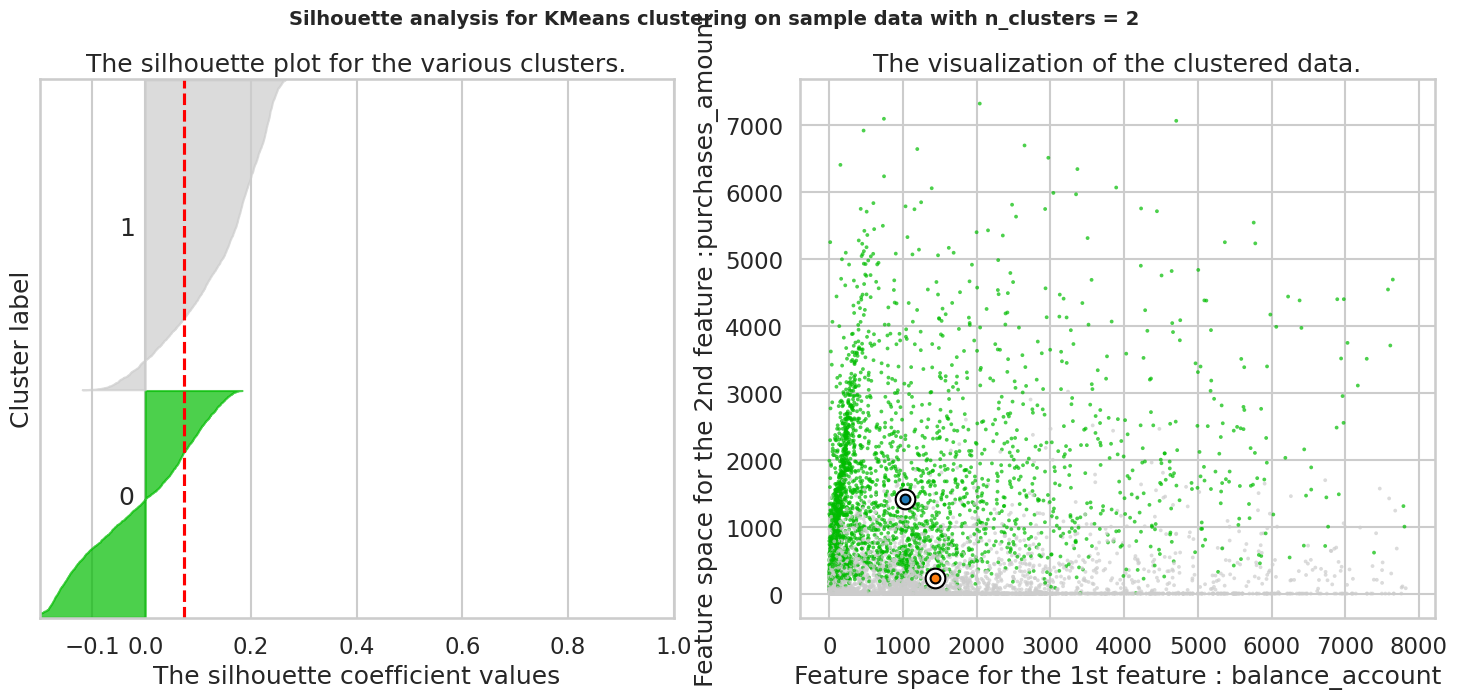

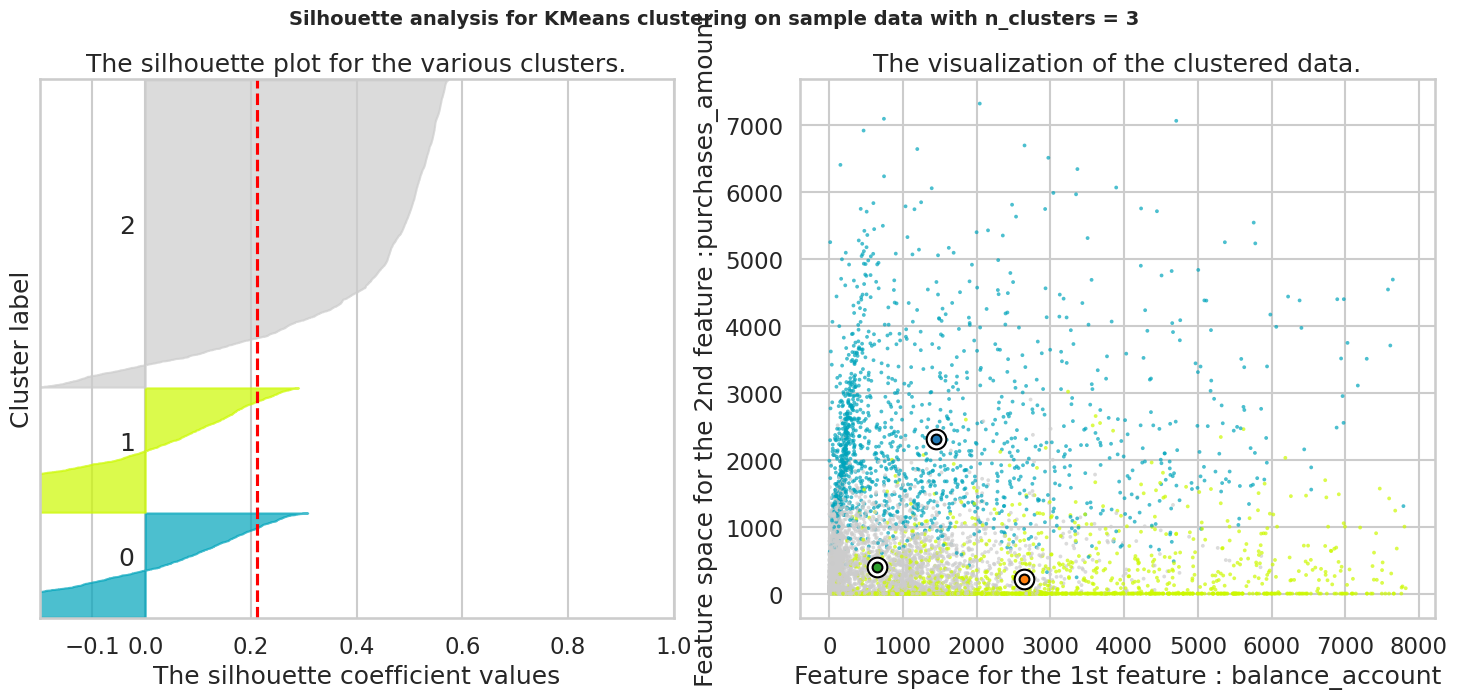

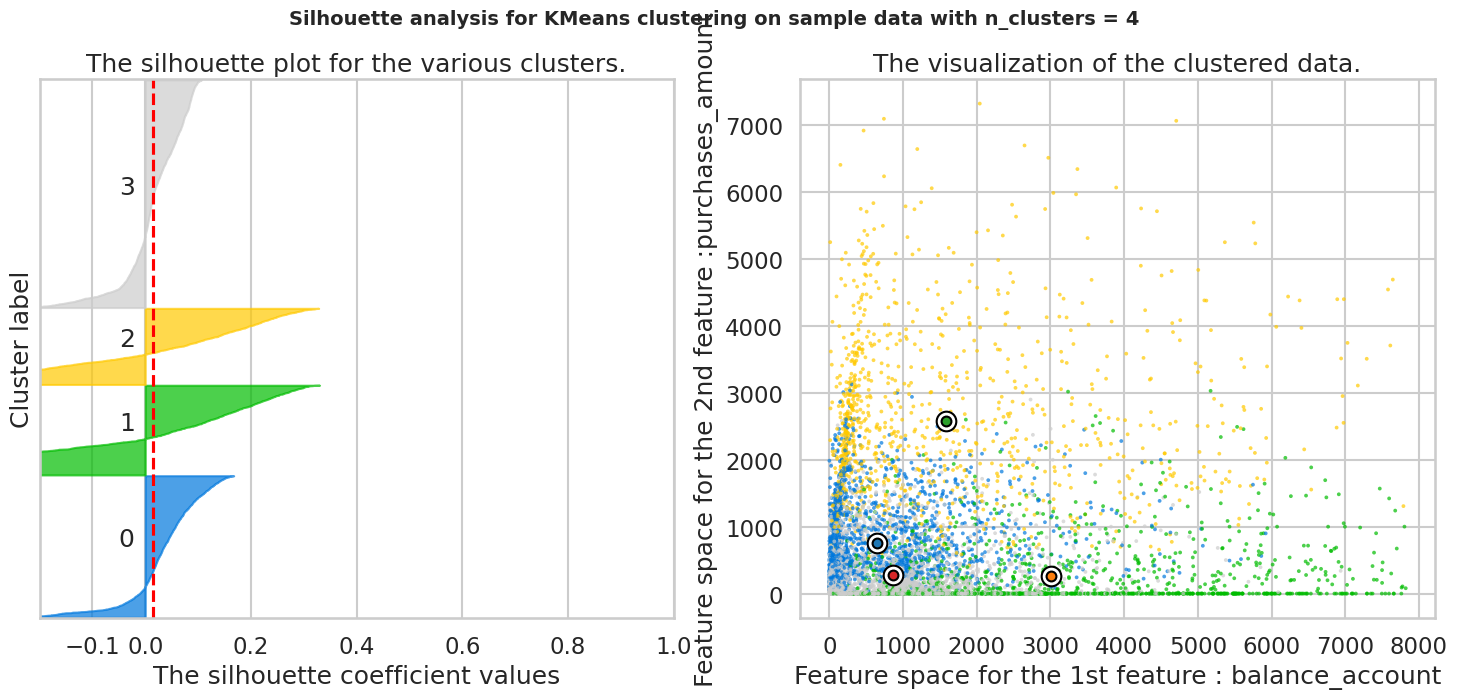

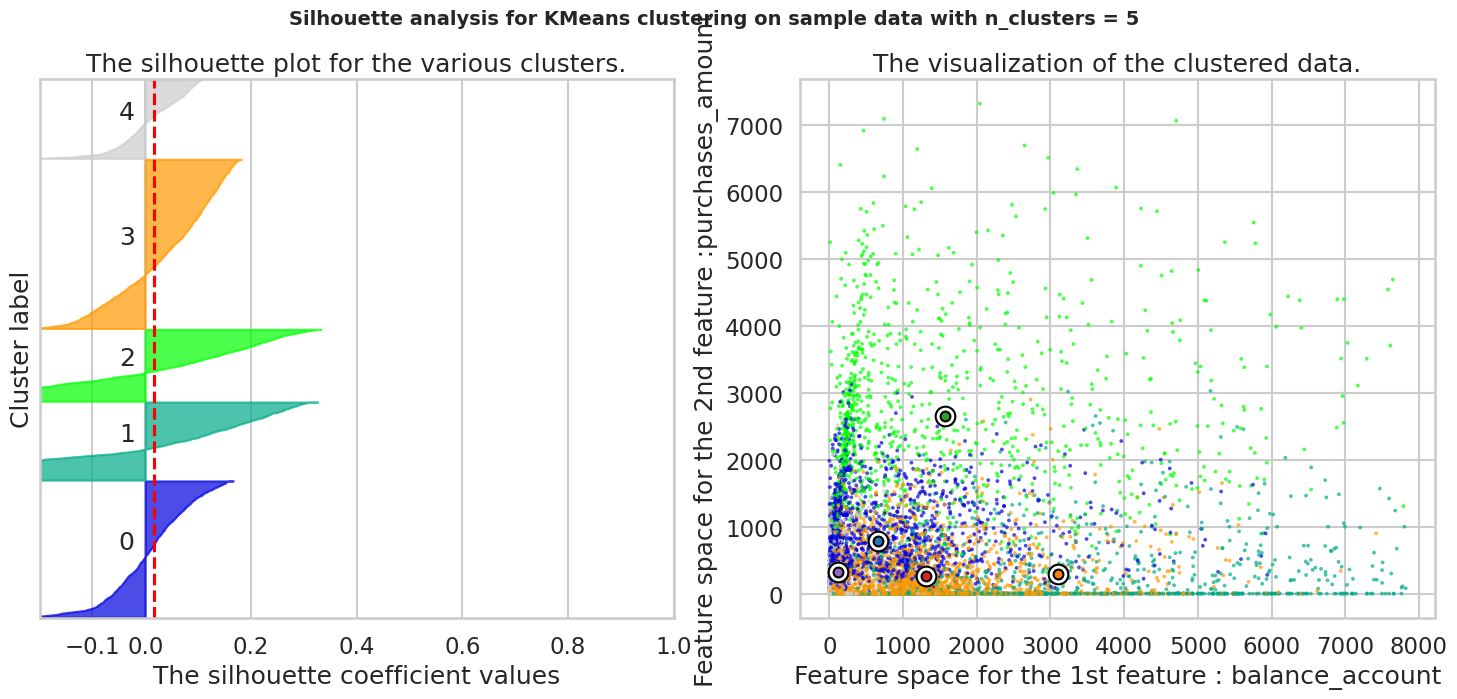

In [ ]:
''' Note: The code below is directly took from sklearn documentation of silhoutte analysis.'''

range_n_clusters = range(2, 6)

r_seed = 17

cols = df_no.columns
X =df_no.to_numpy()

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg.round(4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(X[:, 0],
                X[:, 1],
                marker=".",
                s=30,
                lw=0,
                alpha=0.7,
                c=colors,
                edgecolor="k")

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.show()

### Dimensionality reduction with PCA

In [ ]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit_transform(df_no)

array([[-3.46444358e+03, -5.03302961e+02, -4.80831498e+02, ...,
        -3.23764387e-02, -3.69977345e-02, -1.47594499e-02],
       [-3.45404577e+03, -4.93975411e+02, -4.86610944e+02, ...,
        -7.29906458e-02, -5.91621376e-02, -3.36492741e-02],
       [-2.55624151e+03,  5.95114807e+02, -7.44326767e+02, ...,
        -1.51269865e-01,  3.19618802e-02,  5.27723831e-03],
       ...,
       [-2.98423158e+03, -6.43666169e+02, -5.23328704e+02, ...,
        -1.25738885e-01, -1.32469567e-03,  2.16576904e-02],
       [-8.95621509e+02, -9.87737739e+01, -1.11955366e+02, ...,
        -7.02205235e-02, -1.40672293e-01, -1.95927439e-01],
       [-2.16778248e+02, -3.00650595e+02,  4.77350551e+02, ...,
         3.09680109e-02,  1.95933803e-02,  5.23677887e-02]])

In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.59250212, 0.74820958, 0.87846639, 0.94696901, 0.98358819,
       0.99999266, 0.99999818, 0.99999951, 0.99999999, 0.99999999,
       1.        , 1.        , 1.        , 1.        ])

In [ ]:
df_no.iloc[0:1]

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,payments
0,9.298409,107.6,0.0,0.0,0.909091,107.6,0.909091,0.0,0.818182,0.0,0,10,1000.0,89.868853


In [ ]:
df_no_scaled.iloc[0:1]

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,payments
0,-0.826,-0.619549,-0.552609,-0.535853,0.109407,-0.416225,1.07299,-0.660738,1.182063,-0.698353,-0.592535,-0.114884,-1.000319,-0.819334


In [ ]:
df_pca_new = pd.DataFrame({"feat_1": df_no.dot(pca.components_[0]),
              "feat_2": df_no.dot(pca.components_[1]),
              "feat_3": df_no.dot(pca.components_[2]),
              "feat_4": df_no.dot(pca.components_[3]),
              "feat_5": df_no.dot(pca.components_[4]),
              "feat_6": df_no.dot(pca.components_[5]),
              "feat_7": df_no.dot(pca.components_[6])})
df_pca_new

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7
0,956.930105,-299.849282,-78.012456,94.537002,-1.212008,103.449752,8.221496
1,967.327916,-290.521732,-83.791901,32.240219,-25.564470,148.769613,3.502837
2,1865.132172,798.568485,-341.507725,-368.831064,194.715890,28.976412,-0.073382
3,2595.024165,814.614125,58.921983,-1039.314422,588.728836,-137.384605,9.381959
4,3333.317951,1011.184795,2524.028061,2179.294501,1050.880407,-154.875504,1.671034
...,...,...,...,...,...,...,...
8494,8076.575082,-184.154008,1550.063077,-1286.492267,547.976545,-153.093835,4.697859
8495,8292.580082,-1507.861247,-1514.545475,699.604071,458.008105,-12.289172,-0.416971
8496,1437.142101,-440.212491,-120.509662,145.802801,8.796024,143.065349,8.512625
8498,3525.752175,104.679905,290.863676,-1198.644447,-223.137820,-357.745134,41.881510


For n_clusters = 2 The average silhouette_score is : 0.3673
For n_clusters = 3 The average silhouette_score is : 0.4087
For n_clusters = 4 The average silhouette_score is : 0.3254
For n_clusters = 5 The average silhouette_score is : 0.2737
For n_clusters = 6 The average silhouette_score is : 0.3183
For n_clusters = 7 The average silhouette_score is : 0.2629
For n_clusters = 8 The average silhouette_score is : 0.2598
For n_clusters = 9 The average silhouette_score is : 0.2618
For n_clusters = 10 The average silhouette_score is : 0.1125
For n_clusters = 11 The average silhouette_score is : 0.1105
For n_clusters = 12 The average silhouette_score is : 0.1209
For n_clusters = 13 The average silhouette_score is : 0.1151
For n_clusters = 14 The average silhouette_score is : 0.1092
For n_clusters = 15 The average silhouette_score is : 0.1044
For n_clusters = 16 The average silhouette_score is : 0.0905
For n_clusters = 17 The average silhouette_score is : 0.0942
For n_clusters = 18 The average 

Text(0, 0.5, 'Silhouette Score')

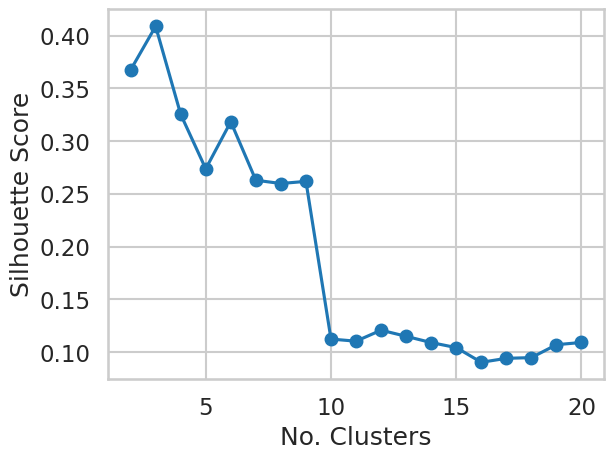

In [ ]:
silhouette_s = []

for n_clusters in range(2, 21):
    kmeans_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=42, verbose=0))])

    cluster_labels = kmeans_pipeline.fit_predict(df_pca_new)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_pca_new, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(df_pca_new, cluster_labels))

plt.plot(range(2, 21),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")

For n_clusters = 2 The average silhouette_score is : 0.3188
For n_clusters = 3 The average silhouette_score is : 0.2327
For n_clusters = 4 The average silhouette_score is : 0.3249
For n_clusters = 5 The average silhouette_score is : 0.2734




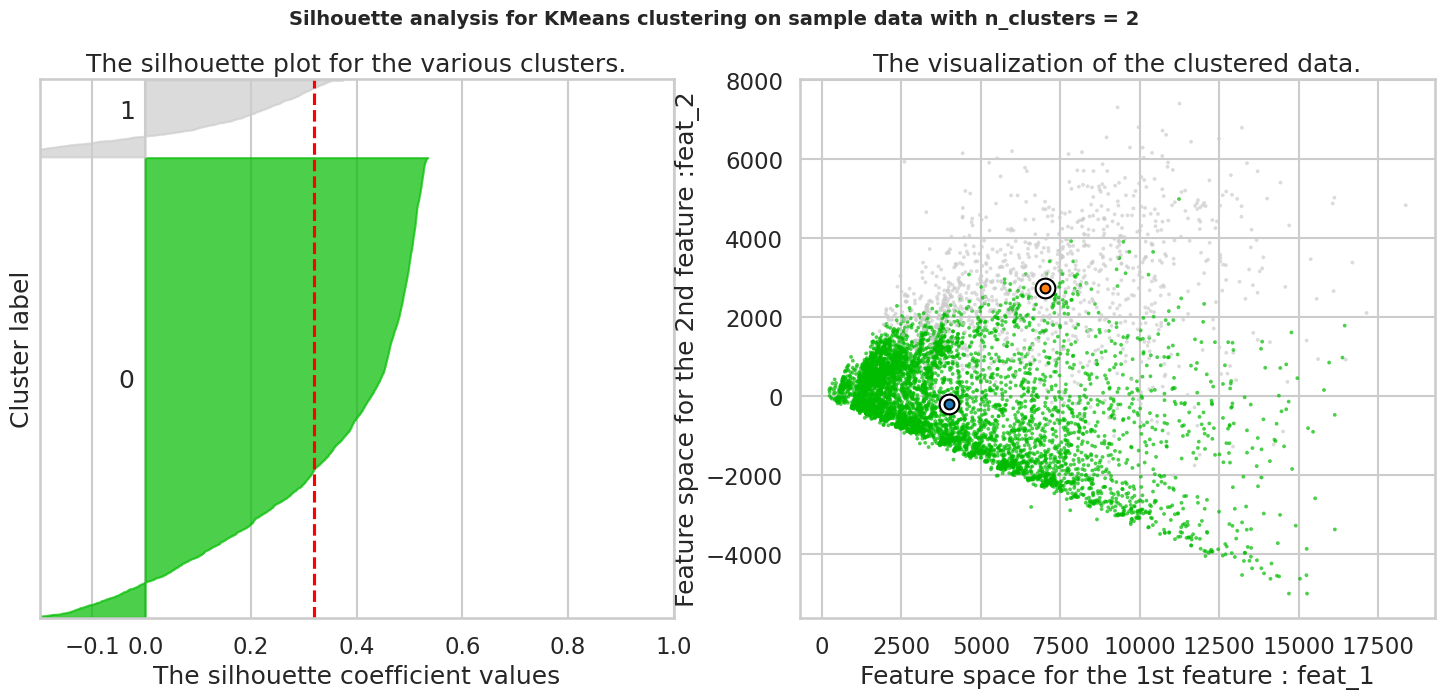

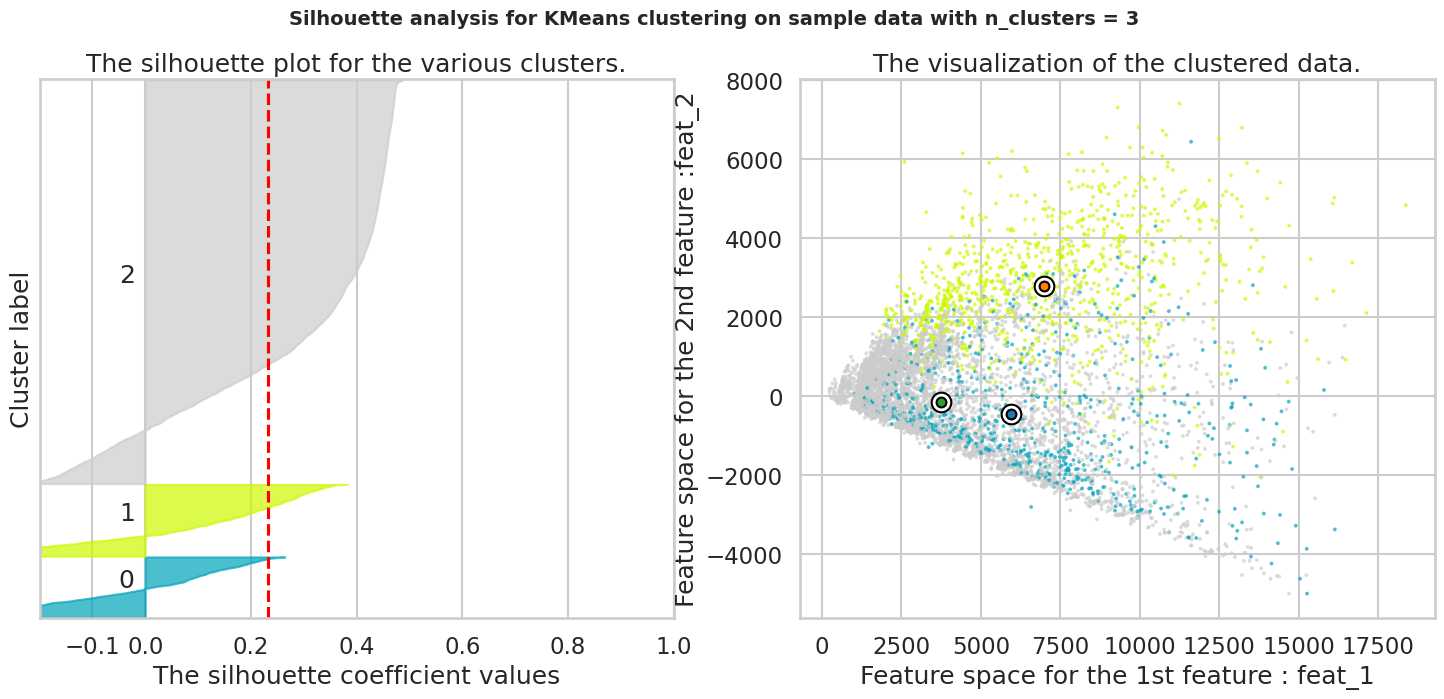

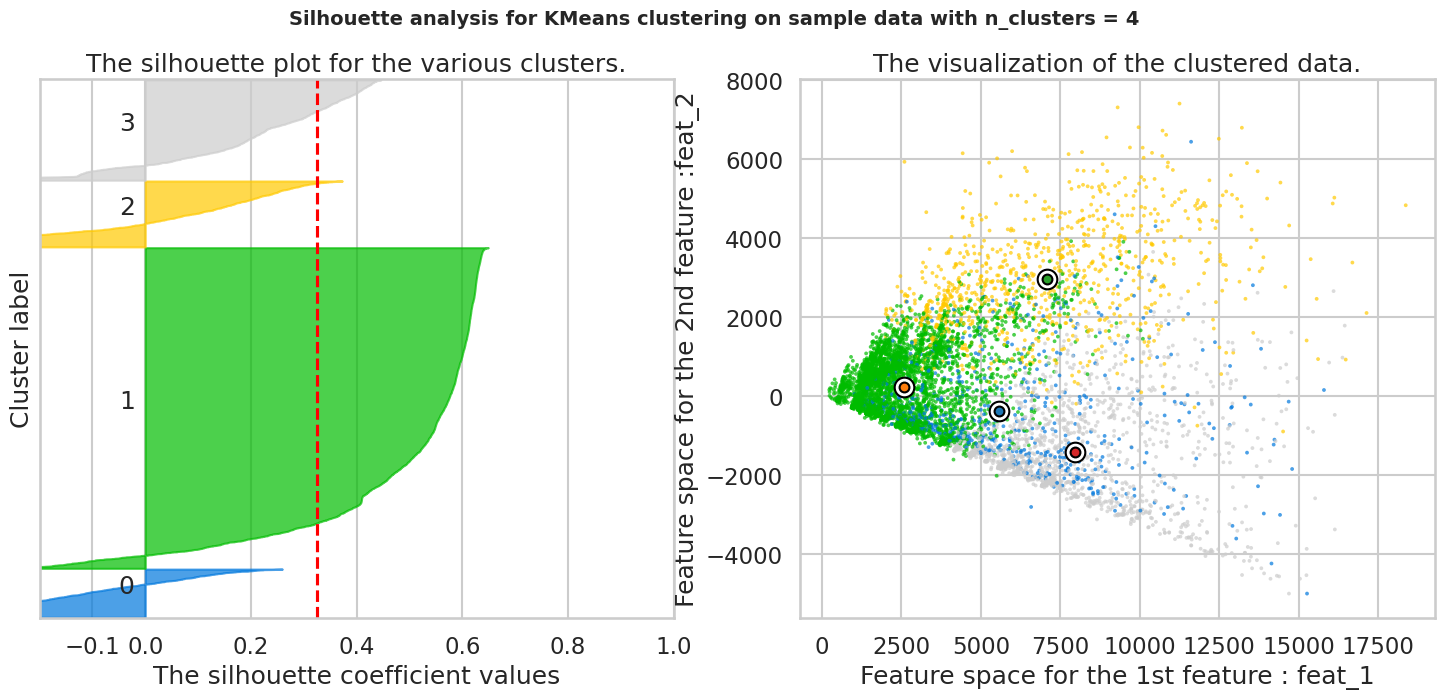

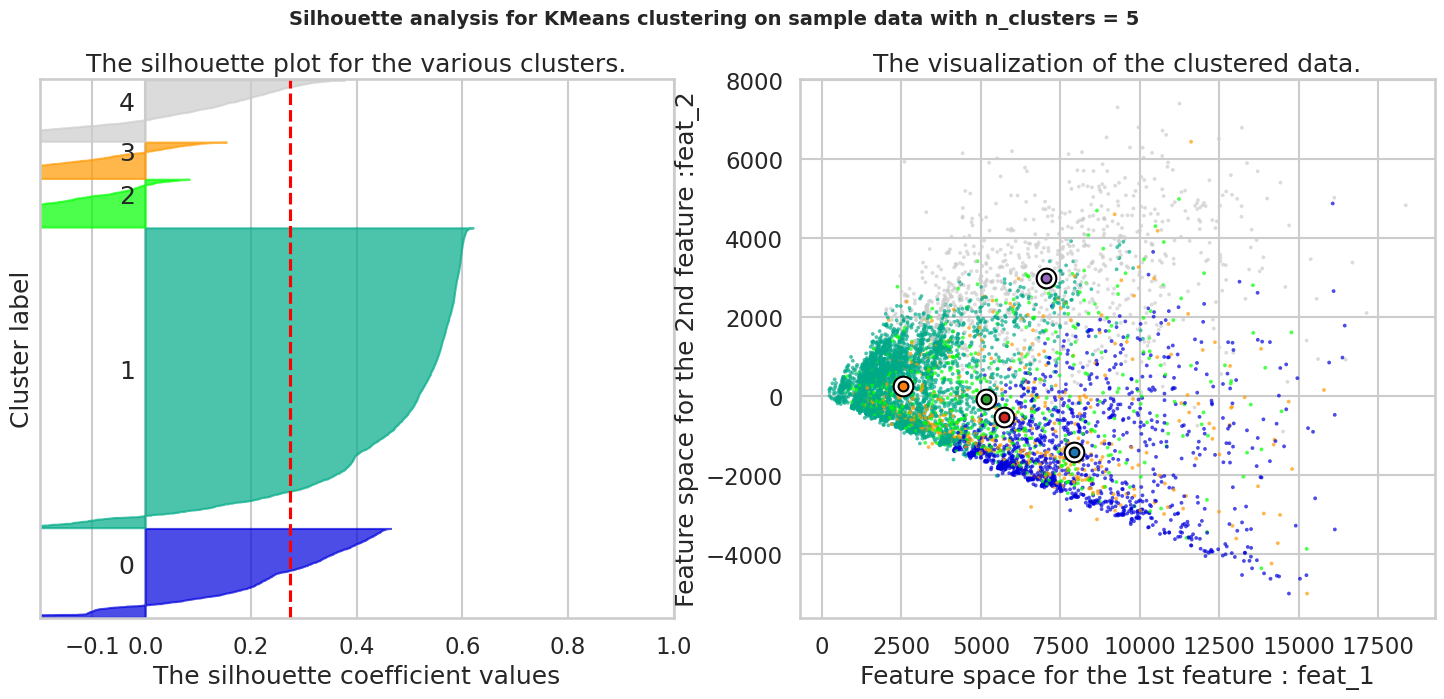

In [ ]:
''' Note: The code below is directly took from sklearn documentation of silhoutte analysis.'''

range_n_clusters = range(2, 6)

r_seed = 17

cols = df_pca_new.columns
X = df_pca_new.to_numpy()

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg.round(4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(X[:, 0],
                X[:, 1],
                marker=".",
                s=30,
                lw=0,
                alpha=0.7,
                c=colors,
                edgecolor="k")

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.show()

### Adding Clusters to the dataset

In [ ]:
kmeans_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=3, random_state=17, verbose=0))])

clusters = kmeans_pipeline.fit_predict(df_pca_new)
df_pca_new['cluster'] = clusters
df_pca_new.head() # Data with 7 transformed features (that explain 90% of variance) along with the cluster prediction

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,cluster
0,956.930105,-299.849282,-78.012456,94.537002,-1.212008,103.449752,8.221496,2
1,967.327916,-290.521732,-83.791901,32.240219,-25.564470,148.769613,3.502837,2
2,1865.132172,798.568485,-341.507725,-368.831064,194.715890,28.976412,-0.073382,2
3,2595.024165,814.614125,58.921983,-1039.314422,588.728836,-137.384605,9.381959,2
4,3333.317951,1011.184795,2524.028061,2179.294501,1050.880407,-154.875504,1.671034,2


In [ ]:
# Add the cluster preditions to the original unscaled dataset

df_clusters = pd.merge(df_no, df_pca_new[["cluster"]], left_index=True, right_index=True)
df_final = pd.merge(df_orig[["customer_id"]], df_clusters, left_index=True, right_index=True)
df_final


,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,payments,cluster
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.60,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,89.868853,2
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.30,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,54.722514,2
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,303.031979,2
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.00,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,704.240770,2
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.00,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,4094.261427,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,UCyeExThOQm4BVuM,2707.058356,2018.13,0.000000,1545.23,1.000000,472.90,0.750000,0.250000,0.666667,0.000000,0,26,7000.0,2575.541309,2
8495,zdVfd3CYHYBjf61b,1127.607606,0.00,271.093275,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.083333,1,0,8500.0,662.387331,2
8496,JGghMowcxhfbVGKm,21.409828,149.71,0.000000,0.00,1.000000,149.71,0.916667,0.000000,0.916667,0.000000,0,11,1500.0,141.974905,2
8498,Ox7ETtYHjE2uo4Xo,1646.384530,1047.34,146.650389,1047.34,1.000000,0.00,0.583333,0.583333,0.000000,0.166667,2,51,3000.0,462.848132,2


## Insights

In [ ]:
# Create summary stats to gather insights from each of the segments

df_3cluster_mean = df_final.groupby(['cluster']).agg(
                {'customer_id': 'count',
                 'balance_account': 'mean',
                 'purchases_amount': 'mean',
                 'paid_advance': 'mean',
                 'full_purchases': 'mean',
                 'balance_frequency_update': 'mean',
                 'installments': 'mean',
                 'purchases_frequency': 'mean',
                 'full_purchases_frequency': 'mean',
                 'purchases_installments_frequency': 'mean',
                 'cash_advance_frequency': 'mean',
                 'nr_cash_advances': 'mean',
                 'nr_purchases': 'mean',
                 'credit_limit': 'mean',
                 'payments': 'mean'
                }).reset_index()
df_3cluster_mean

,cluster,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,payments
0,0,843,1330.808425,2314.526607,287.047316,847.524947,0.951274,1467.001661,0.901109,0.296284,0.836426,0.051856,1.112693,31.408066,5111.962747,2265.153363
1,1,1000,3039.400815,398.548310,3367.867248,277.630090,0.923057,120.918220,0.248017,0.120391,0.153582,0.333133,8.050000,5.992000,5649.504545,2194.920996
2,2,5626,941.269425,553.068519,271.254682,375.450949,0.869065,177.967318,0.462790,0.183366,0.319157,0.082704,1.523107,9.784038,3427.415391,935.080735


In [ ]:
df_3cluster_median = df_final.groupby(['cluster']).agg(
                {'customer_id': 'count',
                 'balance_account': 'median',
                 'purchases_amount': 'median',
                 'paid_advance': 'median',
                 'full_purchases': 'median',
                 'balance_frequency_update': 'median',
                 'installments': 'median',
                 'purchases_frequency': 'median',
                 'full_purchases_frequency': 'median',
                 'purchases_installments_frequency': 'median',
                 'cash_advance_frequency': 'median',
                 'nr_cash_advances': 'median',
                 'nr_purchases': 'median',
                 'credit_limit': 'median',
                 'payments': 'median'
                }).reset_index()
df_3cluster_median

,cluster,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,payments
0,0,843,654.747715,1960.18,0.000000,370.5,1.0,1316.050,1.000000,0.166667,0.916667,0.000000,0.0,27.0,4500.0,1817.791324
1,1,1000,2628.230832,0.00,2995.930713,0.0,1.0,0.000,0.000000,0.000000,0.000000,0.333333,7.0,0.0,5500.0,1478.878768
2,2,5626,503.065900,298.08,0.000000,20.0,1.0,57.935,0.416667,0.083333,0.142857,0.000000,0.0,6.0,2500.0,584.929761


In [ ]:
df_final['cluster'].value_counts(normalize=True)*100 # percentage composition by clusters

2    75.324675
1    13.388673
0    11.286651
Name: cluster, dtype: float64

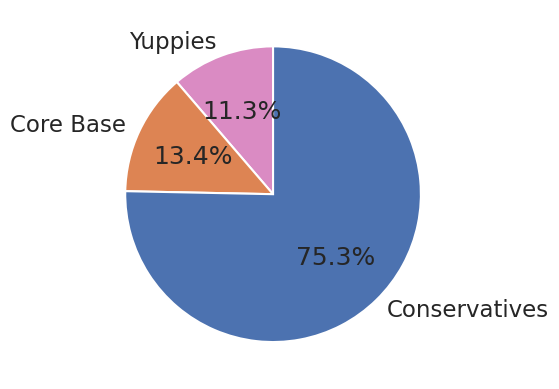

In [ ]:
labels=['Yuppies', 'Core Base', 'Conservatives']
values=[11.286651, 13.388673, 75.324675 ]

colors=['#DA8BC3', '#DD8453', '#4C72B0']
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
#plt.title('Segment shares in %')
plt.show()

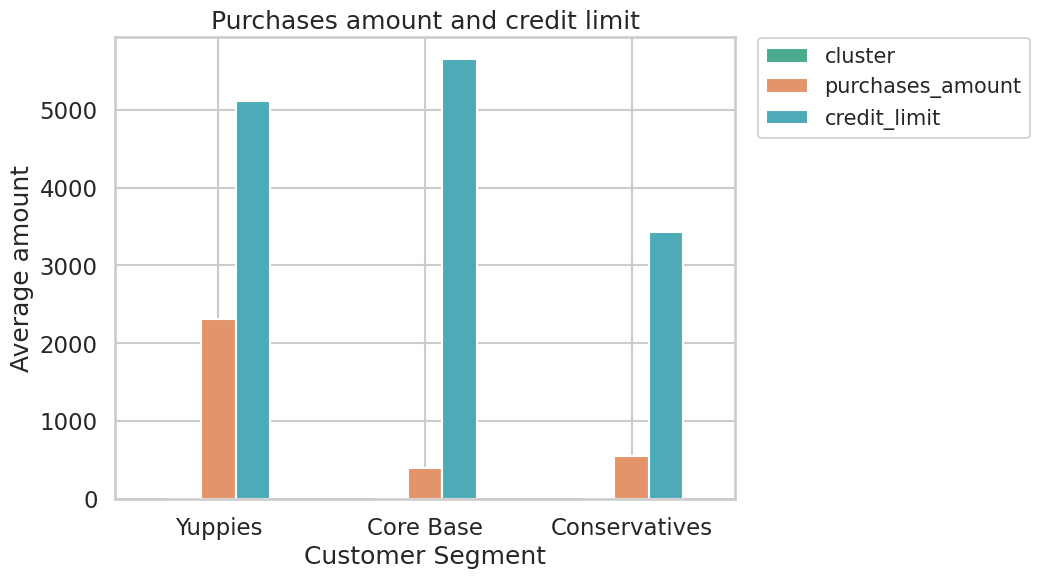

In [ ]:
# Visualizing the three clusters
data1= df_3cluster_mean[['cluster', 'purchases_amount', 'credit_limit']] #subset data to include only three features


#custom_colors = cm.get_cmap('coolwarm', 12)
custom_colors = ['#4BAB8E', '#E4946A', '#4DABB8']

fig, ax = plt.subplots(figsize=(8, 6))

data1.plot(kind='bar', ax=ax, color=custom_colors)
ax.legend(bbox_to_anchor=(1.02, 1.02), fontsize='small')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.ylabel('Average amount')
plt.title('Purchases amount and credit limit');

new_labels=['Yuppies', 'Core Base', 'Conservatives']
plt.xticks(range(len(new_labels)), new_labels)
plt.show()


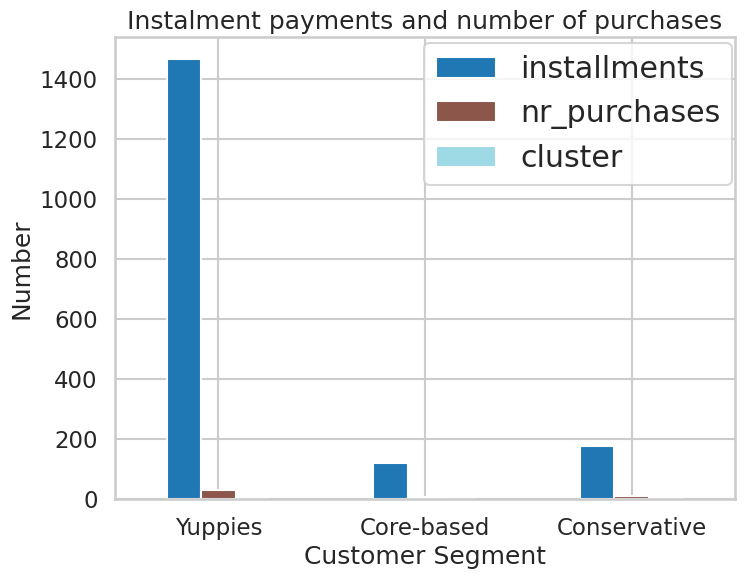

In [ ]:
# Visualizing the three clusters
data2= df_3cluster_mean[['installments', 'nr_purchases', 'cluster']] #subset data to include only three features


custom_colors = cm.get_cmap('tab20', 12)

fig, ax = plt.subplots(figsize=(8, 6))

data2.plot(kind='bar', ax=ax, cmap=custom_colors)
ax.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.ylabel('Number')
plt.title('Instalment payments and number of purchases');

new_labels=['Yuppies', 'Core-based', 'Conservative']
plt.xticks(range(len(new_labels)), new_labels)
plt.show()


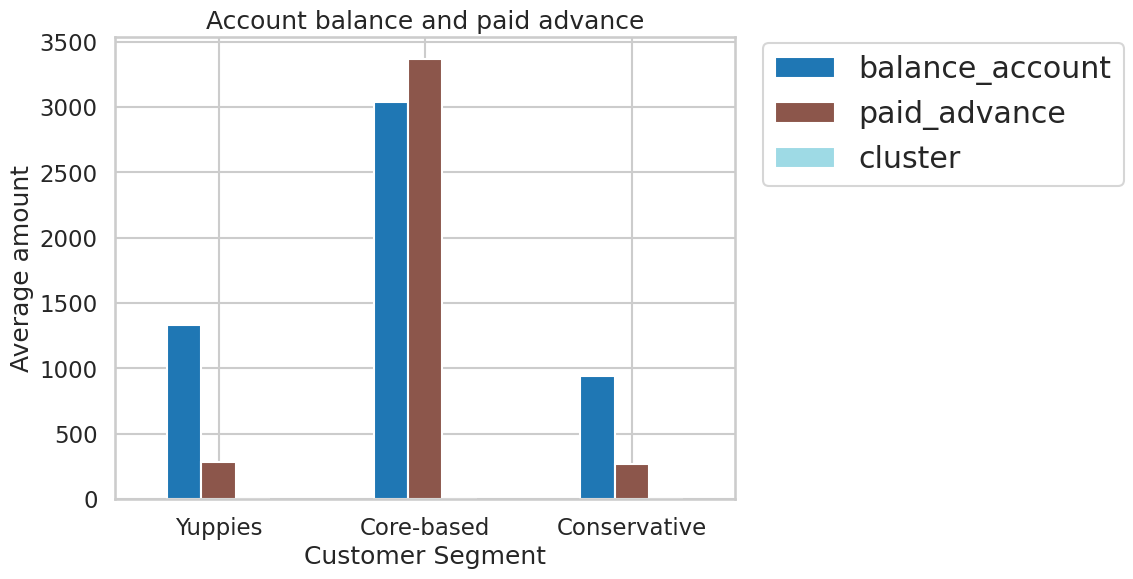

In [ ]:
# Visualizing the three clusters
data3= df_3cluster_mean[['balance_account', 'paid_advance', 'cluster']] #subset data to include only three features


custom_colors = cm.get_cmap('tab20', 12)

fig, ax = plt.subplots(figsize=(8, 6))

data3.plot(kind='bar', ax=ax, cmap=custom_colors)
ax.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.ylabel('Average amount')
plt.title('Account balance and paid advance');

new_labels=['Yuppies', 'Core-based', 'Conservative']
plt.xticks(range(len(new_labels)), new_labels)
plt.show()
